In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MLHDataset/training

/content/drive/.shortcut-targets-by-id/1VRgnSl--37bFORebCzI81ZGMUpDYeFj3/MLHDataset/training


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### MODEL 1 EEGMODEL

In [ ]:
#PART 1 OF THE MODEL, LOADING FILES
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class EEGDataset(Dataset):
    def __init__(self, data, targets):
        if data.ndim == 2:
            data = np.expand_dims(data, axis=1)  # Add a channel dimension if missing
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Load train, val, and test data and targets
base_path = '/content/drive/MyDrive/MLHDataset/training'


# Old files - trying with raw data (no PSD) - high computational power
'''
with open(f'{base_path}/combined_normalized_train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open(f'{base_path}/combined_normalized_val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)

with open(f'{base_path}/combined_normalized_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open(f'{base_path}/combined_normalized_train_target.pkl', 'rb') as f:
    train_target_list = pickle.load(f)

with open(f'{base_path}/combined_normalized_val_target.pkl', 'rb') as f:
    val_target_list = pickle.load(f)

with open(f'{base_path}/combined_normalized_test_target.pkl', 'rb') as f:
    test_target_list = pickle.load(f)'''


with open(f'{base_path}/train_psd.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(f'{base_path}/val_psd.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(f'{base_path}/test_psd.pkl', 'rb') as f:
    test_data = pickle.load(f)
with open(f'{base_path}/train_target_psd.pkl', 'rb') as f:
    train_target_list = pickle.load(f)
with open(f'{base_path}/val_target_psd.pkl', 'rb') as f:
    val_target_list = pickle.load(f)
with open(f'{base_path}/test_target_psd.pkl', 'rb') as f:
    test_target_list = pickle.load(f)

In [ ]:
print("Converting data to numpy arrays...")
train_data = np.array(train_data, dtype=np.float32)
val_data = np.array(val_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)

train_target_list = np.array(train_target_list, dtype=np.int64)
val_target_list = np.array(val_target_list, dtype=np.int64)
test_target_list = np.array(test_target_list, dtype=np.int64)
print("Data conversion complete!")

print("Creating datasets and DataLoaders...")
train_dataset = EEGDataset(train_data, train_target_list)
val_dataset = EEGDataset(val_data, val_target_list)
test_dataset = EEGDataset(test_data, test_target_list)

# Set batch size   # Tried 32, 64, 128, 256, 512 and 1024 as well
batch_size = 1024 * 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("Datasets and DataLoaders ready!")

class EEGModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

print("Initializing model...")
input_channels = train_data.shape[1]
num_classes = len(np.unique(train_target_list)) +2
model = EEGModel(input_channels, num_classes)
print(f"Model initialized with {input_channels} input channels and {num_classes} output classes.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.permute(0, 1,2)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    print(f"Epoch [{epoch + 1}/{num_epochs}] complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training complete!")

# Evaluation loop
print("Starting evaluation...")
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
val_preds, val_labels = [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == targets).sum().item()

print("Validation complete!")
val_acc = val_correct / val_total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")

# Test loop
print("Starting testing...")
test_loss, test_correct, test_total = 0, 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1,2)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

print("Testing complete!")
test_acc = test_correct / test_total * 100
print(f"Test Accuracy: {test_acc:.2f}%")


Converting data to numpy arrays...
Data conversion complete!
Creating datasets and DataLoaders...
Datasets and DataLoaders ready!
Initializing model...
Model initialized with 5 input channels and 6 output classes.
Starting training...
Epoch 1/10
Epoch [1/10] complete. Loss: 1.8211, Accuracy: 0.87%
Epoch 2/10
Epoch [2/10] complete. Loss: 1.8144, Accuracy: 3.04%
Epoch 3/10
Epoch [3/10] complete. Loss: 1.8079, Accuracy: 6.67%
Epoch 4/10
Epoch [4/10] complete. Loss: 1.8014, Accuracy: 15.38%
Epoch 5/10
Epoch [5/10] complete. Loss: 1.7951, Accuracy: 22.92%
Epoch 6/10
Epoch [6/10] complete. Loss: 1.7889, Accuracy: 29.43%
Epoch 7/10
Epoch [7/10] complete. Loss: 1.7828, Accuracy: 29.90%
Epoch 8/10
Epoch [8/10] complete. Loss: 1.7767, Accuracy: 29.98%
Epoch 9/10
Epoch [9/10] complete. Loss: 1.7708, Accuracy: 30.53%
Epoch 10/10
Epoch [10/10] complete. Loss: 1.7649, Accuracy: 30.57%
Training complete!
Starting evaluation...
Validation complete!
Validation Accuracy: 26.67%
Starting testing...
Testi

Skipping Class 0 (not present in test labels)


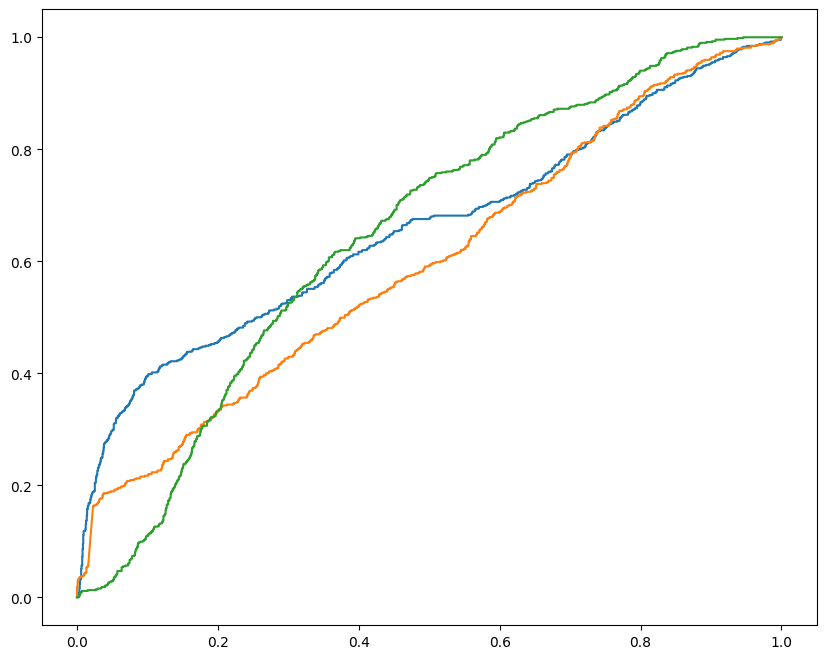

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

num_classes = test_probs.shape[1]

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    # Check if the class is present in the ground truth labels
    if np.sum(test_labels == i) > 0:
        fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
        roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        print(f"Skipping Class {i} (not present in test labels)")


plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

all_preds = predicted.cpu().numpy()
all_targets = targets.cpu().numpy()

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)


accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"\n\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))


Confusion Matrix:
[[327 309   0  14]
 [ 59 585   0   1]
 [145 556   0   4]
 [ 68 588   0   4]]


Accuracy: 34.44%
Precision (Weighted): 0.2462
Recall (Weighted): 0.3444
F1 Score (Weighted): 0.2366

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.50      0.52       650
           2       0.29      0.91      0.44       645
           3       0.00      0.00      0.00       705
           5       0.17      0.01      0.01       660

    accuracy                           0.34      2660
   macro avg       0.25      0.35      0.24      2660
weighted avg       0.25      0.34      0.24      2660



#### MODEL 2 RESNET

In [ ]:
# Read psd and psd target files from pickle files

with open('/content/drive/MyDrive/MLHDataset/training/train_psd.pkl', 'rb') as f:
    train_psd_segmented = pickle.load(f)

with open('/content/drive/MyDrive/MLHDataset/training/val_psd.pkl', 'rb') as f:
    val_psd_segmented = pickle.load(f)

with open('/content/drive/MyDrive/MLHDataset/training/test_psd.pkl', 'rb') as f:
    test_psd_segmented = pickle.load(f)

with open('/content/drive/MyDrive/MLHDataset/training/train_target_psd.pkl', 'rb') as f:
    train_target_list_psd = pickle.load(f)

with open('/content/drive/MyDrive/MLHDataset/training/val_target_psd.pkl', 'rb') as f:
    val_target_list_psd = pickle.load(f)

with open('/content/drive/MyDrive/MLHDataset/training/test_target_psd.pkl', 'rb') as f:
    test_target_list_psd =pickle.load(f)

sampled_train_data = train_psd_segmented
sampled_val_data = val_psd_segmented
sampled_test_data = test_psd_segmented

sampled_train_target_list = train_target_list_psd
sampled_val_target_list = val_target_list_psd
sampled_test_target_list = test_target_list_psd

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, data, targets):
        print("data ndmin", data.ndim)
        if data.ndim == 2:
            data = np.expand_dims(data, axis=1)
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [ ]:
# Mapping labels from 1, 2, 3, 5 to 0, 1, 2, 3

class_mapping = {1: 0, 2: 1, 3: 2, 5: 3}
sampled_train_target_list = [class_mapping[label] for label in sampled_train_target_list]
sampled_val_target_list = [class_mapping[label] for label in sampled_val_target_list]
sampled_test_target_list = [class_mapping[label] for label in sampled_test_target_list]

print(sampled_train_target_list[:])
print(sampled_val_target_list[:])
print(sampled_test_target_list[:])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
batch_size = 64

train_dataset = EEGDataset(sampled_train_data, sampled_train_target_list)
val_dataset = EEGDataset(sampled_val_data, sampled_val_target_list)
test_dataset = EEGDataset(sampled_test_data, sampled_test_target_list)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)

data ndmin 3
data ndmin 3
data ndmin 3


In [ ]:
#RESNET MODEL TRYING WITH PSD
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=4):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self.gn1 = nn.GroupNorm(groups, out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2)
        self.gn2 = nn.GroupNorm(groups, out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.GroupNorm(groups, out_channels),
            )
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.gn2(out)
        out = self.dropout(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes, block_channels=[64, 128, 256], groups=4):
        super(ResNet1D, self).__init__()
        self.input_conv = nn.Conv1d(input_channels, block_channels[0], kernel_size=7, stride=1, padding=3)
        self.input_gn = nn.GroupNorm(groups, block_channels[0])
        self.relu = nn.ReLU(inplace=True)
        self.layers = self._make_layers(block_channels, groups)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(block_channels[-1], num_classes)
        self.input_dropuout = nn.Dropout(p=0.3)
        self.fc_dropout = nn.Dropout(p=0.7)

    def _make_layers(self, block_channels, groups):
        layers = []
        for i in range(len(block_channels) - 1):
            layers.append(
                ResidualBlock(block_channels[i], block_channels[i + 1], kernel_size=3, stride=1, groups=groups)
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.input_gn(x)
        x = self.relu(x)
        x = self.input_dropuout(x)
        x = self.layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for FC layer
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x

# EEG Dataset class
class EEGDataset(Dataset):
    def __init__(self, data, targets):
        if data.ndim == 2:
            data = np.expand_dims(data, axis=1)
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

base_path = '/content/drive/MyDrive/MLHDataset/training'

with open(f'{base_path}/train_psd.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(f'{base_path}/val_psd.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(f'{base_path}/test_psd.pkl', 'rb') as f:
    test_data = pickle.load(f)
with open(f'{base_path}/train_target_psd.pkl', 'rb') as f:
    train_target_list = pickle.load(f)
with open(f'{base_path}/val_target_psd.pkl', 'rb') as f:
    val_target_list = pickle.load(f)
with open(f'{base_path}/test_target_psd.pkl', 'rb') as f:
    test_target_list = pickle.load(f)


train_data = np.array(train_data, dtype=np.float32)
val_data = np.array(val_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)

train_target_list = np.array(train_target_list, dtype=np.int64)
val_target_list = np.array(val_target_list, dtype=np.int64)
test_target_list = np.array(test_target_list, dtype=np.int64)

train_dataset = EEGDataset(train_data, train_target_list)
val_dataset = EEGDataset(val_data, val_target_list)
test_dataset = EEGDataset(test_data, test_target_list)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model
input_channels = train_data.shape[1]
num_classes = len(np.unique(train_target_list))+2
model = ResNet1D(input_channels=input_channels, num_classes=num_classes, block_channels=[64, 128, 256], groups=4)
model.to(DEVICE)

# Training setup
criterion = nn.CrossEntropyLoss()
criterion.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=4e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training and validation loop
num_epochs = 25
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs} - Starting...")

    # Training phase
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    print(f"Training - Epoch {epoch + 1}")
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        print(f"  Training - Batch {batch_idx + 1}/{len(train_loader)}")
        inputs = inputs.permute(0, 1, 2)  # (batch_size, channels, time_steps)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total * 100
    print(f"  Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    print(f"Validation - Epoch {epoch + 1}")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            print(f"  Validation - Batch {batch_idx + 1}/{len(val_loader)}")
            inputs = inputs.permute(0, 1,2)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100
    print(f"  Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Adjust learning rate
    scheduler.step()
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

# Testing loop
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
print("\nTesting Phase")
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        print(f"  Testing - Batch {batch_idx + 1}/{len(test_loader)}")
        inputs = inputs.permute(0, 1,2)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

test_loss /= len(test_loader)
test_acc = test_correct / test_total * 100
print(f"Testing - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

Streaming output truncated to the last 5000 lines.
  Training - Batch 148/159
  Training - Batch 149/159
  Training - Batch 150/159
  Training - Batch 151/159
  Training - Batch 152/159
  Training - Batch 153/159
  Training - Batch 154/159
  Training - Batch 155/159
  Training - Batch 156/159
  Training - Batch 157/159
  Training - Batch 158/159
  Training - Batch 159/159
  Training - Loss: 0.8886, Accuracy: 60.83%
Validation - Epoch 6
  Validation - Batch 1/83
  Validation - Batch 2/83
  Validation - Batch 3/83
  Validation - Batch 4/83
  Validation - Batch 5/83
  Validation - Batch 6/83
  Validation - Batch 7/83
  Validation - Batch 8/83
  Validation - Batch 9/83
  Validation - Batch 10/83
  Validation - Batch 11/83
  Validation - Batch 12/83
  Validation - Batch 13/83
  Validation - Batch 14/83
  Validation - Batch 15/83
  Validation - Batch 16/83
  Validation - Batch 17/83
  Validation - Batch 18/83
  Validation - Batch 19/83
  Validation - Batch 20/83
  Validation - Batch 21/83
  

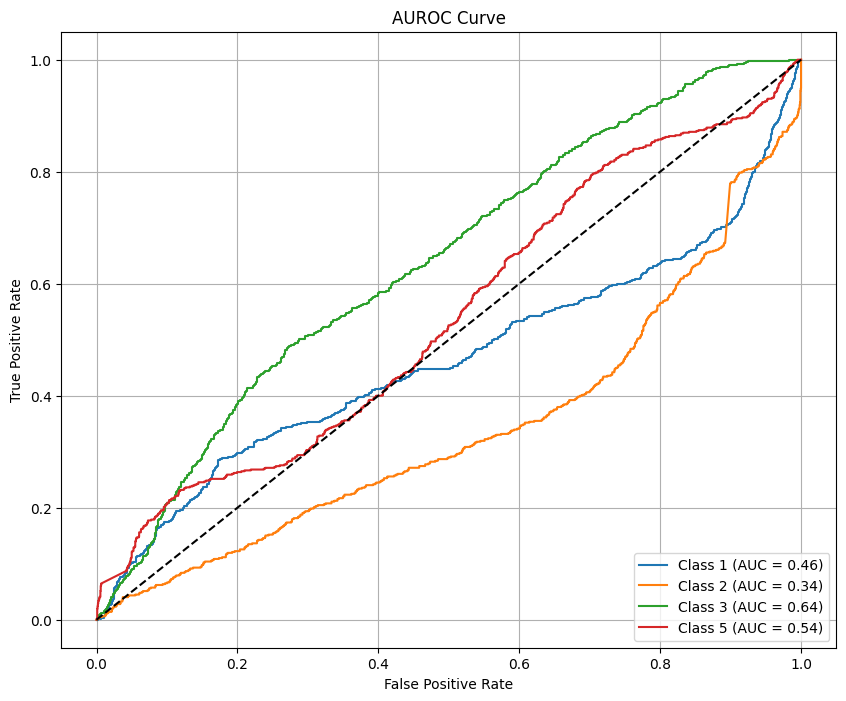

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Collect predictions and probabilities during the test loop - this is used for AUROC for all models
test_labels = []
test_probs = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        inputs = inputs.permute(0, 1, 2)  # (batch_size, channels, time_steps)
        outputs = model(inputs)

        probabilities = torch.softmax(outputs, dim=1)

        test_probs.extend(probabilities.cpu().numpy())
        test_labels.extend(targets.cpu().numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)

num_classes = test_probs.shape[1]

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    # Check if the class is present in the test labels
    if np.sum(test_labels == i) > 0:
        fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
        roc_auc = roc_auc_score(test_labels == i, test_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        print(f" ")

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


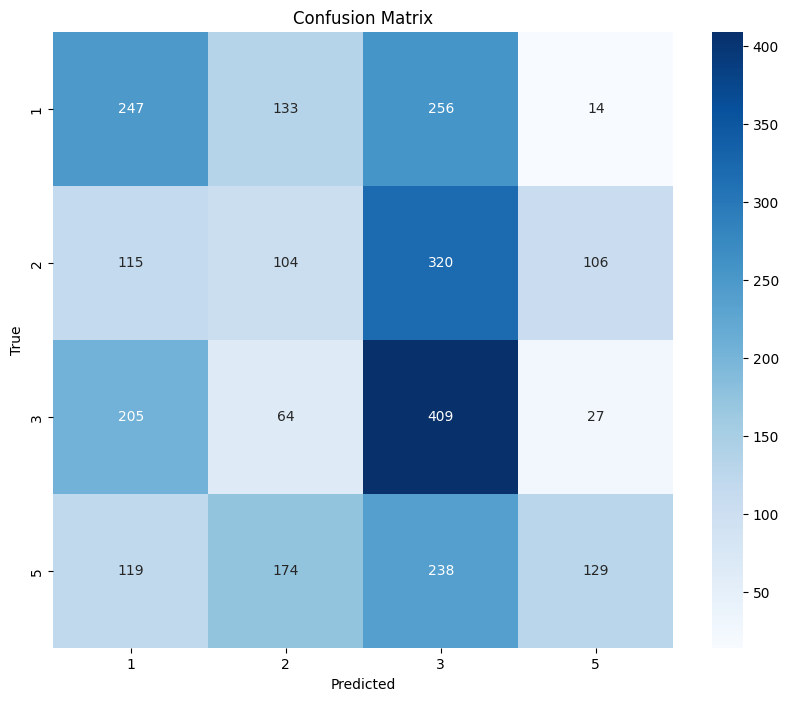

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(train_target_list), yticklabels=np.unique(train_target_list))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)


accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"\n\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))


Confusion Matrix:
[[247 133 256  14]
 [115 104 320 106]
 [205  64 409  27]
 [119 174 238 129]]


Accuracy: 33.42%
Precision (Weighted): 0.3457
Recall (Weighted): 0.3342
F1 Score (Weighted): 0.3162

Classification Report:
              precision    recall  f1-score   support

           1       0.36      0.38      0.37       650
           2       0.22      0.16      0.19       645
           3       0.33      0.58      0.42       705
           5       0.47      0.20      0.28       660

    accuracy                           0.33      2660
   macro avg       0.35      0.33      0.31      2660
weighted avg       0.35      0.33      0.32      2660



#### MODEL 3 XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np


# Flattening data
X_train = sampled_train_data.reshape(sampled_train_data.shape[0], -1)
X_val = sampled_val_data.reshape(sampled_val_data.shape[0], -1)
X_test = sampled_test_data.reshape(sampled_test_data.shape[0], -1)

y_train = np.array(sampled_train_target_list)
y_val = np.array(sampled_val_target_list)
y_test = np.array(sampled_test_target_list)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,  # Number of classes
    'eval_metric': 'merror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'silent': 1
}

# Training
num_round = 100
evals = [(dtrain, 'train'), (dval, 'eval')]

model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10)

y_pred = model.predict(dtest)
y_pred = np.round(y_pred).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[0]	train-merror:0.03895	eval-merror:0.09270
[1]	train-merror:0.01331	eval-merror:0.04734
[2]	train-merror:0.00888	eval-merror:0.04142
[3]	train-merror:0.00592	eval-merror:0.02959
[4]	train-merror:0.00542	eval-merror:0.02761
[5]	train-merror:0.00493	eval-merror:0.02761
[6]	train-merror:0.00493	eval-merror:0.02959
[7]	train-merror:0.00493	eval-merror:0.02761
[8]	train-merror:0.00444	eval-merror:0.03156
[9]	train-merror:0.00345	eval-merror:0.02959
[10]	train-merror:0.00345	eval-merror:0.02761
[11]	train-merror:0.00296	eval-merror:0.03156
[12]	train-merror:0.00296	eval-merror:0.02959
[13]	train-merror:0.00296	eval-merror:0.02761
[14]	train-merror:0.00247	eval-merror:0.02564
[15]	train-merror:0.00247	eval-merror:0.02367
[16]	train-merror:0.00247	eval-merror:0.02367
[17]	train-merror:0.00197	eval-merror:0.02564
[18]	train-merror:0.00148	eval-merror:0.02564
[19]	train-merror:0.00148	eval-merror:0.02564
[20]	train-merror:0.00049	eval-merror:0.02367
[21]	train-merror:0.00049	eval-merror:0.0236

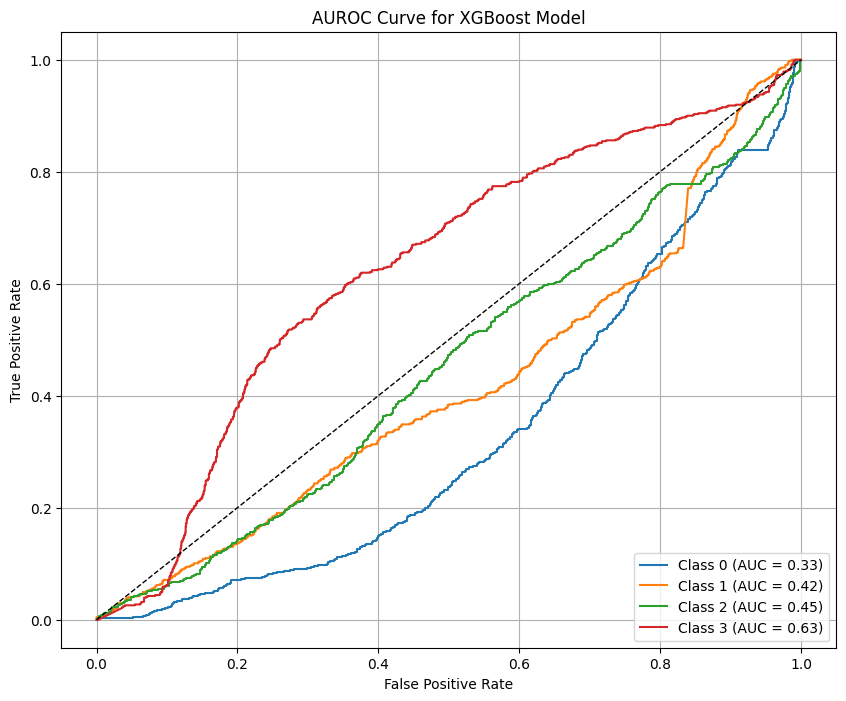

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

y_probs = model.predict(dtest)  # Shape: (num_samples, num_classes)

# One-hot encode the ground truth labels
num_classes = params['num_class']
y_test_bin = np.zeros((len(y_test), num_classes))
y_test_bin[np.arange(len(y_test)), y_test] = 1

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    # Check if the class is present in the ground truth
    if np.sum(y_test_bin[:, i]) > 0:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        print(f"Skipping Class {i} (not present in test labels)")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


#### MODEL 4 SIMPLE CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np

print("Loading data...")
base_path = '/content/drive/MyDrive/MLHDataset/training'

with open(f'{base_path}/train_psd.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(f'{base_path}/val_psd.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open(f'{base_path}/test_psd.pkl', 'rb') as f:
    test_data = pickle.load(f)
with open(f'{base_path}/train_target_psd.pkl', 'rb') as f:
    train_target_list = pickle.load(f)
with open(f'{base_path}/val_target_psd.pkl', 'rb') as f:
    val_target_list = pickle.load(f)
with open(f'{base_path}/test_target_psd.pkl', 'rb') as f:
    test_target_list = pickle.load(f)
print("Data loaded successfully!")

print("Converting data to numpy arrays...")
train_data = np.array(train_data, dtype=np.float32)
val_data = np.array(val_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)

train_target_list = np.array(train_target_list, dtype=np.int64)
val_target_list = np.array(val_target_list, dtype=np.int64)
test_target_list = np.array(test_target_list, dtype=np.int64)
print("Data conversion complete!")

if train_data.ndim == 2:
    print("Data is 2D. Adding a dummy channel dimension...")
    train_data = np.expand_dims(train_data, axis=1)
    val_data = np.expand_dims(val_data, axis=1)
    test_data = np.expand_dims(test_data, axis=1)
print(f"Adjusted train_data shape: {train_data.shape}")

print("Creating datasets and DataLoaders...")
class EEGDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

train_dataset = EEGDataset(train_data, train_target_list)
val_dataset = EEGDataset(val_data, val_target_list)
test_dataset = EEGDataset(test_data, test_target_list)

# Set batch size
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("Datasets and DataLoaders ready!")

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes, input_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * (input_size // 4), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("Initializing Simple CNN model...")
input_channels = train_data.shape[1]
input_size = train_data.shape[2]
num_classes = len(np.unique(train_target_list)) +2
print(f"Input channels: {input_channels}, Input size: {input_size}, Number of classes: {num_classes}")

model = SimpleCNN(input_channels, num_classes, input_size)
print(f"Model initialized successfully:\n{model}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 10
print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.permute(0, 1, 2)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    print(f"Epoch [{epoch + 1}/{num_epochs}] complete. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training complete!")

# Evaluation loop
print("Starting evaluation...")
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
val_preds, val_labels = [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.permute(0, 1,2)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == targets).sum().item()

print("Validation complete!")
val_acc = val_correct / val_total * 100
print(f"Validation Accuracy: {val_acc:.2f}%")

# Test loop
print("Starting testing...")
test_loss, test_correct, test_total = 0, 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1,2)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

print("Testing complete!")
test_acc = test_correct / test_total * 100
print(f"Test Accuracy: {test_acc:.2f}%")


Loading data...
Data loaded successfully!
Converting data to numpy arrays...
Data conversion complete!
Adjusted train_data shape: (2535, 5, 18)
Creating datasets and DataLoaders...
Datasets and DataLoaders ready!
Initializing Simple CNN model...
Input channels: 5, Input size: 18, Number of classes: 6
Model initialized successfully:
SimpleCNN(
  (conv1): Conv1d(5, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
Starting training...
Epoch 1/20
Epoch [1/20] complete. Loss: 1.5213, Accuracy: 37.20%
Epoch 2/20
Epoch [2/20] complete. Loss: 1.2507, Accuracy: 44.93%
Epoch 3/20
Epoch [3/20] complete. Loss: 1.1507, Accuracy: 48.21%
Epoch 4/20
Epoch [4/20]

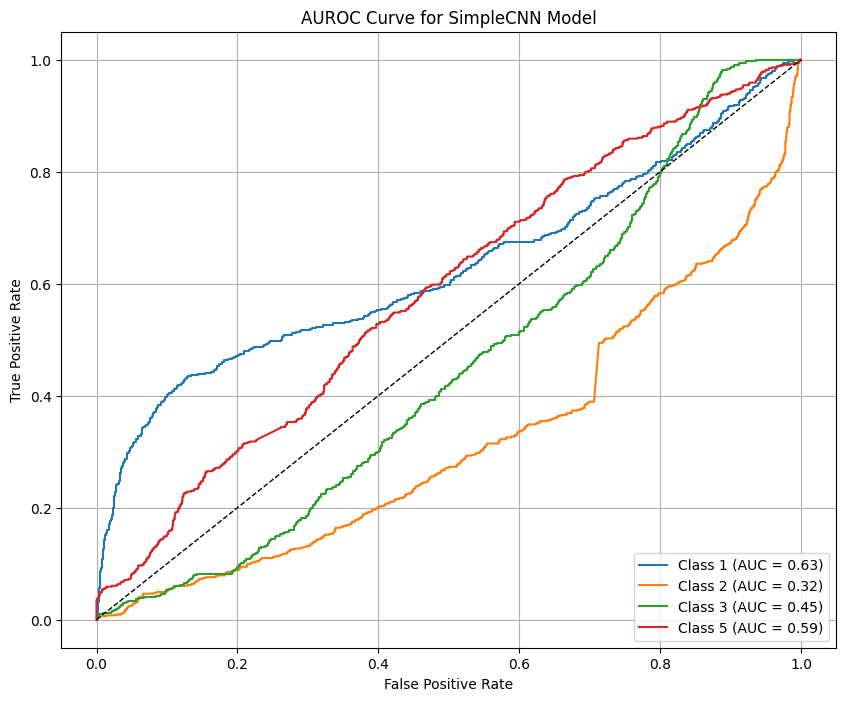

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

test_labels = []
test_probs = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1, 2)  # (batch_size, channels, time_steps)
        outputs = model(inputs)

        # Softmax is used here to convert logits to probs
        probabilities = torch.softmax(outputs, dim=1)

        test_probs.extend(probabilities.cpu().numpy())
        test_labels.extend(targets.cpu().numpy())

test_probs = np.array(test_probs)  # Shape: (num_samples, num_classes)
test_labels = np.array(test_labels)  # Shape: (num_samples,)

num_classes = test_probs.shape[1]
test_labels_bin = np.zeros((len(test_labels), num_classes))
test_labels_bin[np.arange(len(test_labels)), test_labels] = 1

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    # Check if the class is present in the ground truth labels
    if np.sum(test_labels == i) > 0:
        fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
        roc_auc = roc_auc_score(test_labels_bin[:, i], test_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        print(f"")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve for SimpleCNN Model')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import torch

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized)

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))


Confusion Matrix:
[[443 183  11  13]
 [323  81 136 105]
 [435 244  15  11]
 [435 109  28  88]]
Normalized Confusion Matrix:
[[0.68153846 0.28153846 0.01692308 0.02      ]
 [0.50077519 0.1255814  0.21085271 0.1627907 ]
 [0.61702128 0.34609929 0.0212766  0.01560284]
 [0.65909091 0.16515152 0.04242424 0.13333333]]
Accuracy: 23.57%
Precision (Weighted): 0.2195
Recall (Weighted): 0.2357
F1 Score (Weighted): 0.1845

Classification Report:
              precision    recall  f1-score   support

           1       0.27      0.68      0.39       650
           2       0.13      0.13      0.13       645
           3       0.08      0.02      0.03       705
           5       0.41      0.13      0.20       660

    accuracy                           0.24      2660
   macro avg       0.22      0.24      0.19      2660
weighted avg       0.22      0.24      0.18      2660



####Model 5 EEGMODEL with 5-fold cross validation

In [ ]:
import pickle
import os
# Read from /content/drive/MyDrive/MLHDataset/training/target_data_splits.pkl

with open('/content/drive/MyDrive/MLHDataset/training/target_data_splits.pkl', 'rb') as f:
    target_data_splits = pickle.load(f)

# Read from /content/drive/MyDrive/MLHDataset/training/unsqueezed_splits_data_loaded.pkl

with open('/content/drive/MyDrive/MLHDataset/training/unsqueezed_splits_data_loaded.pkl', 'rb') as f:
    unsqueezed_splits_data_loaded =pickle.load(f)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import numpy as np

class EEGDataset(Dataset):
    def __init__(self, data, labels):

        print("data shape", len(data))
        print(f"Initializing EEGDataset with data type: {type(data)}, labels type: {type(labels)}")
        print(f"Data shape before processing: {np.shape(data)}, Labels shape: {np.shape(labels)}")

        data = np.asarray(data)
        labels = np.asarray(labels)


        # if np.asarray(data).ndim == 2:
        #     data = np.expand_dims(data, axis=0)
        # self.data = torch.tensor(data, dtype=torch.float32)
        # self.labels = torch.tensor(labels, dtype=torch.long)

        # print("Length of data and labels", len(self.data), len(self.labels))
        # print("data", self.data.shape)
        # print("labels", self.labels.shape)

        # assert len(self.data) == len(self.labels), "Data and labels must have same length"

        data = np.asarray(data)
        labels = np.asarray(labels)

        if data.ndim == 2:
          # (samples, time_steps) -> (samples, channels=1, time_steps)
          data = data[:, np.newaxis, :]
        elif data.ndim == 3:
          # Ensure shape is (samples, channels, time_steps)
          data = np.transpose(data, (0, 2, 1))

        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = self.data[idx]
        label = self.labels[idx]
        return feature, label

def create_dataloader(data_splits, target_splits, batch_size=20*5, shuffle=False):

    # print("data spits keys", data_splits.keys())

    for dataset_type in data_splits.keys():     # ['train', 'test']

        train_dataset = EEGDataset(
            data_splits['train'],
            target_splits['train']
        )

        test_dataset = EEGDataset(
            data_splits['test'],
            target_splits['test']
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader,test_loader



In [ ]:
# Model

import torch.nn as nn

class EEGModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.mean(x, dim=2)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

def train_and_evaluate(splits, base_dir, num_epochs, batch_size, input_channels, num_classes):
    results = {}

    for fold_idx, fold_data in splits.items():  # Use splits directly
        print(f"\nFold {fold_idx + 1}/{len(splits)}")

        train_loader, test_loader = create_dataloader(fold_data, target_data_splits[fold_idx])

        # model is re-initialized for each fold
        model = EEGModel(input_channels, num_classes)
        criterion = CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss, correct, total = 0.0, 0, 0
            for inputs, targets in train_loader:
                inputs = inputs.permute(0, 2, 1)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

            train_acc = 100.0 * correct / total
            print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Testing loop
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.permute(0, 2, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_acc = 100.0 * correct / total
        print(f"Fold {fold_idx + 1} - Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
        results[fold_idx] = {'test_loss': test_loss, 'test_accuracy': test_acc}

    return results

results = train_and_evaluate(
    splits=unsqueezed_splits_data_loaded,
    base_dir= "/content/drive/MyDrive/MLHDataset/training",
    num_epochs=10,
    batch_size=100,
    input_channels=18,
    num_classes=6
)



Fold 1/5
data shape 36075
Initializing EEGDataset with data type: <class 'list'>, labels type: <class 'list'>
Data shape before processing: (36075, 18), Labels shape: (36075,)
data shape 12525
Initializing EEGDataset with data type: <class 'list'>, labels type: <class 'list'>
Data shape before processing: (12525, 18), Labels shape: (12525,)
data shape 36075
Initializing EEGDataset with data type: <class 'list'>, labels type: <class 'list'>
Data shape before processing: (36075, 18), Labels shape: (36075,)
data shape 12525
Initializing EEGDataset with data type: <class 'list'>, labels type: <class 'list'>
Data shape before processing: (12525, 18), Labels shape: (12525,)
Epoch 1/10 - Train Loss: 520.4981, Accuracy: 58.76%
Epoch 2/10 - Train Loss: 510.6634, Accuracy: 52.45%
Epoch 3/10 - Train Loss: 475.5236, Accuracy: 47.22%
Epoch 4/10 - Train Loss: 598.6823, Accuracy: 14.41%
Epoch 5/10 - Train Loss: 454.6209, Accuracy: 43.20%
Epoch 6/10 - Train Loss: 484.2243, Accuracy: 52.50%
Epoch 7/10

F1 Score: 0.1870


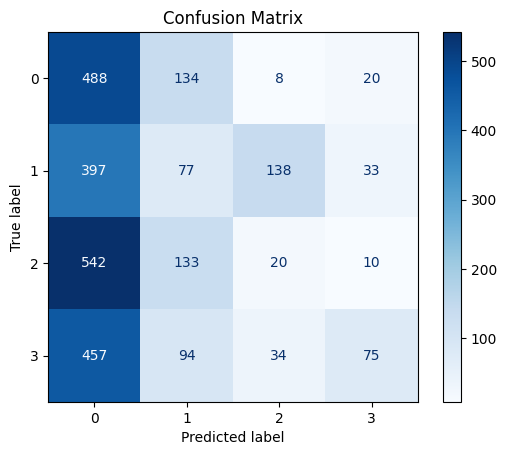

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_predictions(model, test_loader, input_channels, num_classes):
    model.eval()
    all_targets, all_predictions = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.permute(0, 1, 2)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f"F1 Score: {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return {'confusion_matrix': cm, 'f1_score': f1}


results = evaluate_predictions(model, test_loader, input_channels=18, num_classes=6)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 1, 2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds))


Confusion Matrix:
[[488 134   8  20]
 [397  77 138  33]
 [542 133  20  10]
 [457  94  34  75]]
Normalized Confusion Matrix:
[[0.75076923 0.20615385 0.01230769 0.03076923]
 [0.61550388 0.11937984 0.21395349 0.05116279]
 [0.76879433 0.18865248 0.02836879 0.0141844 ]
 [0.69242424 0.14242424 0.05151515 0.11363636]]
Accuracy: 24.81%
Precision (Weighted): 0.2673
Recall (Weighted): 0.2481
F1 Score (Weighted): 0.1870

Classification Report:
              precision    recall  f1-score   support

           1       0.26      0.75      0.39       650
           2       0.18      0.12      0.14       645
           3       0.10      0.03      0.04       705
           5       0.54      0.11      0.19       660

    accuracy                           0.25      2660
   macro avg       0.27      0.25      0.19      2660
weighted avg       0.27      0.25      0.19      2660

